# Exercise 6: CNN with SGD, MC Dropout, and Epistemic Uncertainty

Train a controlled convolutional neural network (CNN) on a subset of the SVHN dataset using the SGD optimizer.
Then, apply Monte Carlo (MC) Dropout at inference to estimate both test accuracy and epistemic uncertainty.
Set random seeds to 42. Use the following configuration:

**Data Preparation**
- Load SVHN and normalize pixel values to [0, 1]
- Use only the first 2000 training samples and first 500 test samples
- Input shape: 32 × 32 × 3

**CNN Architecture**
- Conv2D: 32 filters, 3×3 kernel, ReLU activation
- MaxPooling2D: 2×2
- Conv2D: 64 filters, 3×3 kernel, ReLU activation
- MaxPooling2D: 2×2
- Flatten
- Dense: 128 neurons, ReLU activation
- Dropout: 0.25 (keep during inference for MC Dropout)
- Output layer: 10 neurons with softmax activation

**Training Configuration**
- Optimizer: SGD with momentum = 0.9, learning_rate = 0.01
- Loss: sparse_categorical_crossentropy
- Epochs: 15
- Batch size: 32

**Monte Carlo Dropout**
- Enable dropout during inference
- Average predictions over 20 stochastic forward passes
- Compute the epistemic uncertainty as the predictive variance across passes

## Questions

**Q6.1**

Report the plain test accuracy of the CNN trained with SGD (no MC Dropout).
    
**Q6.2**

Report the MC Dropout–enhanced accuracy (averaging 20 stochastic predictions).

**Q6.3**

Compute the average epistemic uncertainty (mean predictive variance) across all test samples.
Report it as a deterministic number rounded to three decimal places.

Number of training examples: 2000
tfds.core.DatasetInfo(
    name='svhn_cropped',
    full_name='svhn_cropped/3.1.0',
    description="""
    The Street View House Numbers (SVHN) Dataset is an image digit recognition
    dataset of over 600,000 digit images coming from real world data. Images are
    cropped to 32x32.
    """,
    homepage='http://ufldl.stanford.edu/housenumbers/',
    data_dir='/Users/arthurborgerthorkildsen/tensorflow_datasets/svhn_cropped/3.1.0',
    file_format=tfrecord,
    download_size=1.47 GiB,
    dataset_size=1.09 GiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'extra': <SplitInfo num_examples=531131, num_shards=8>,
        'test': <SplitInfo num_examples=26032, num_shards=1>,
  

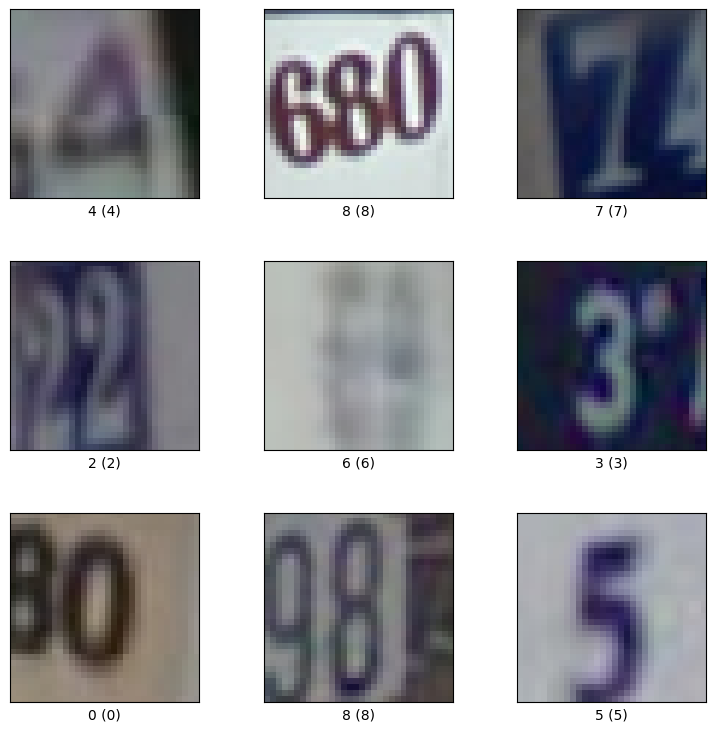

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1950 - loss: 2.2639 - val_accuracy: 0.1840 - val_loss: 2.2592
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1955 - loss: 2.2452 - val_accuracy: 0.1840 - val_loss: 2.2500
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1955 - loss: 2.2416 - val_accuracy: 0.1840 - val_loss: 2.2470
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1955 - loss: 2.2393 - val_accuracy: 0.1840 - val_loss: 2.2473
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1970 - loss: 2.2316 - val_accuracy: 0.1840 - val_loss: 2.2324
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1960 - loss: 2.2140 - val_accuracy: 0.1840 - val_loss: 2.2207
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2160 - loss: 2.1672 - val_accuracy: 0.2280 - val_loss: 2.1621
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2775 - loss: 2.0592 - val_accuracy: 0.3140 - val_loss:

In [18]:
# load SVHN dataset
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

train_size = 2000
test_size = 500

# Construct a tf.data.Dataset, load only the first 2000 training and 500 test examples
ds_train, info = tfds.load('svhn_cropped', split=f'train[:{train_size}]', as_supervised=True, with_info=True)
# Check the number of examples in the training dataset
print("Number of training examples:", ds_train.cardinality().numpy())
print(info) 
ds_test = tfds.load('svhn_cropped', split=f'test[:{test_size}]', as_supervised=True)
print("Number of test examples:", ds_test.cardinality().numpy())
# print the class names
print("Class names:", info.features['label'].names)

# Display some examples from the dataset
tfds.show_examples(ds_train, info, rows=3, cols=3);

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label
ds_train = ds_train.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

# Build the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(10, activation='softmax')]
)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Train the model
history = model.fit(ds_train, batch_size=32, epochs=15, validation_data=ds_test)
# Q6.1
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Test Accuracy (SGD): {test_accuracy:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


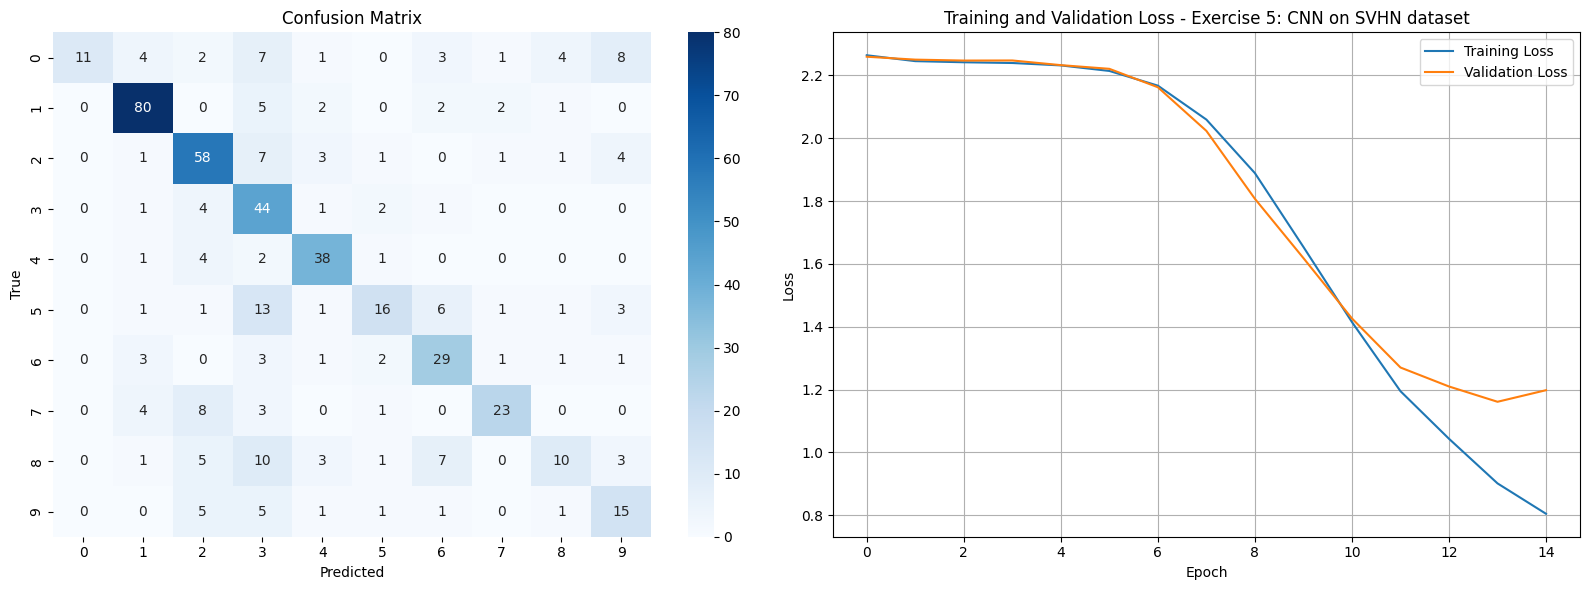

In [21]:
from helper import plot_model_evaluation
import numpy as np

# Extract x_test and y_test as numpy arrays from the dataset
x_test_list = []
y_test_list = []
for images, labels in ds_test:
    x_test_list.append(images.numpy())
    y_test_list.append(labels.numpy())

x_test = np.concatenate(x_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

plot_model_evaluation(model, x_test, y_test, history, exercise_title='Exercise 5: CNN on SVHN dataset')

## Q6.2

Report the MC Dropout–enhanced accuracy (averaging 20 stochastic predictions).

In [19]:
# Q6.2: MC Dropout - Enable dropout during inference
import numpy as np

# Extract test data as numpy arrays
x_test_list = []
y_test_list = []
for images, labels in ds_test:
    # Append batch data to lists
    x_test_list.append(images.numpy())
    y_test_list.append(labels.numpy())

# Concatenate all batches to form complete test sets
x_test = np.concatenate(x_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

# Perform 20 stochastic forward passes with dropout enabled
mc_iterations = 20
mc_predictions = []

for i in range(mc_iterations):
    # Use training=True to enable dropout during inference (make predictions on unseen data)
    predictions = model(x_test, training=True)
    mc_predictions.append(predictions.numpy())

# Average predictions across all MC iterations
mc_predictions = np.array(mc_predictions) 
mc_mean_predictions = np.mean(mc_predictions, axis=0)

# Get predicted classes from averaged predictions
mc_predicted_classes = np.argmax(mc_mean_predictions, axis=1)

# Calculate MC Dropout accuracy, compare with true labels
mc_accuracy = np.mean(mc_predicted_classes == y_test)
# Print 5 first predicted classes and true labels for verification
print("First 5 MC Dropout predicted classes:", mc_predicted_classes[:5])
print("First 5 true labels:", y_test[:5])
print(f'Q6.2 MC Dropout-enhanced accuracy: {mc_accuracy * 100:.2f}%')

First 5 MC Dropout predicted classes: [2 7 2 4 4]
First 5 true labels: [2 7 2 4 4]
Q6.2 MC Dropout-enhanced accuracy: 63.60%


The enhanced MC Dropout accuracy means that we take the average of the predictions from multiple stochastic forward passes through the network with dropout enabled during inference. This helps to capture the uncertainty in the model's predictions and can lead to improved accuracy.

## Q6.3 
Compute the average epistemic uncertainty (mean predictive variance) across all test samples.
Report it as a deterministic number rounded to three decimal places.

In [20]:
prediction_variance = np.var(mc_predictions, axis=0)

# Mean variance across all classes for each sample
mean_variance_per_sample = np.mean(prediction_variance, axis=1)

# Average epistemic uncertainty across all test samples
epistemic_uncertainty = np.mean(mean_variance_per_sample)
print(f'Q6.3 Average epistemic uncertainty: {epistemic_uncertainty:.3f}')

Q6.3 Average epistemic uncertainty: 0.006


The average epistemic uncertainty is calculated by measuring the variance in the predictions across the multiple stochastic forward passes. This variance reflects the model's uncertainty about its predictions, and averaging it across all test samples provides a single measure of uncertainty for the entire test set.